In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

### <font color=blue> CovidHub ensemble state predictions

In [2]:
# import glob
# import os
# from tqdm.notebook import tqdm 

# my_dir = os.path.join(DATA_DIR,'raw','COVIDhub-ensemble')
# files = glob.glob(f'{my_dir}/*.csv')

# # types = ['point']
# # targets = ['1 wk ahead inc death']

# all_dfs = []
# for f in tqdm(files,total=len(files)):
#     df = pd.read_csv(f)
#     ## Choose which types (only point for now)
# #     df = df[df.type=='point']
#     ## Only 1 wk ahead inc
# #     df = df[df.target.isin(targets)]
#     all_dfs.append(df)
# df_all = pd.concat(all_dfs)
# # df_all.sort_values(['Fips','Date'], inplace=True)
# df_all.reset_index(drop=True,inplace=True)
# display(df_all)


In [3]:
timestamp = '20241002-004543'

fpath = os.path.join(DATA_DIR,'processed', f'processed_naive_deaths_{timestamp}.csv')
df = pd.read_csv(fpath)
# display(df)

## Drop rows with nans.
df.dropna(inplace=True)
# display(df)

## Drop samples with negative inc deaths.
df_deaths = df[df.True_inc_deaths >= 0]
# display(df_deaths)
df_deaths

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,Naive_inc_deaths
1,1001,1,58239,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,0.970738
2,1001,1,58239,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,0.794509
3,1001,1,58239,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,0.888429
4,1001,1,58239,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,1.029708
5,1001,1,58239,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,1.331723
...,...,...,...,...,...,...,...,...,...,...,...
312331,56045,56,6891,576641,0.011950,20220409,8.000000,18.0,18.0,0.0,0.095602
312332,56045,56,6891,576641,0.011950,20220416,5.000000,18.0,18.0,0.0,0.059751
312333,56045,56,6891,576641,0.011950,20220423,4.000000,18.0,18.0,0.0,0.047801
312334,56045,56,6891,576641,0.011950,20220430,4.000000,18.0,18.0,0.0,0.047801


### <font color=blue> Get performance of naive prediction for each county.

In [4]:
from epsampling.utils import get_performance
import pprint

county_res_dict = {}

fipss = df_deaths.Fips.unique()

for fips in tqdm(df_deaths.Fips.unique(), total = len(fipss)):
    
    df_fips = df_deaths[df_deaths.Fips==fips]
    
    y_naive = df_fips['Naive_inc_deaths'].values
    y_test = df_fips['True_inc_deaths'].values

    model_names = ['Naive_inc_deaths'] #,'Deaths_true']
    model_preds = [y_naive]
    
    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
    county_res_dict[fips] = list(metrics_dict.values())[0]
    
df_res = pd.DataFrame([[county,metric,value] 
                       for county,d in county_res_dict.items() 
                       for metric,value in d.items()], 
                       columns = ['Fips','metric','value'])

df = df_res.pivot(index='Fips',columns='metric',values='value')
# df.drop('relMAE',axis=1,inplace=True)

df.reset_index(inplace=True)
df.columns.name = None
df.index.name = None

dff = df.merge(df_deaths[['Fips','Pop','Ratio']], on='Fips')
dff.drop_duplicates(inplace=True)
df = dff[['Fips', 'Pop', 'Ratio', 'MAE', 'relMAE', 'MSE', 'RMSE', 'r2']]
display(df)

100%|██████████| 3131/3131 [00:04<00:00, 753.50it/s]


,Fips,Pop,Ratio,MAE,relMAE,MSE,RMSE,r2
0,1001,58239,0.011653,1.442469,1.0,4.288161,2.070788,0.300375
96,1003,227131,0.045447,5.212893,1.0,65.629623,8.101211,0.171386
194,1005,25259,0.005054,0.897593,1.0,4.181049,2.044761,0.047110
292,1007,22412,0.004484,0.966661,1.0,5.255706,2.292533,0.023673
389,1009,58884,0.011782,1.489784,1.0,5.462142,2.337123,0.373556
...,...,...,...,...,...,...,...,...
306269,56037,42459,0.073632,1.002291,1.0,2.748585,1.657886,0.312222
306368,56039,23319,0.040439,0.580852,1.0,0.667827,0.817207,-2.952518
306467,56041,20514,0.035575,0.537657,1.0,0.670594,0.818898,-0.011463
306566,56043,7768,0.013471,0.472109,1.0,0.945976,0.972613,0.063673


#### Remove largest county.

In [5]:
max_pop = df.Pop.max()
df = df[df.Pop < max_pop]
# df

In [7]:
## normalize mae by pop size

df['normMAE'] = df.apply(lambda x: x.MAE / x.Pop, axis=1)
df

,Fips,Pop,Ratio,MAE,relMAE,MSE,RMSE,r2,normMAE
0,1001,58239,0.011653,1.442469,1.0,4.288161,2.070788,0.300375,0.000025
96,1003,227131,0.045447,5.212893,1.0,65.629623,8.101211,0.171386,0.000023
194,1005,25259,0.005054,0.897593,1.0,4.181049,2.044761,0.047110,0.000036
292,1007,22412,0.004484,0.966661,1.0,5.255706,2.292533,0.023673,0.000043
389,1009,58884,0.011782,1.489784,1.0,5.462142,2.337123,0.373556,0.000025
...,...,...,...,...,...,...,...,...,...
306269,56037,42459,0.073632,1.002291,1.0,2.748585,1.657886,0.312222,0.000024
306368,56039,23319,0.040439,0.580852,1.0,0.667827,0.817207,-2.952518,0.000025
306467,56041,20514,0.035575,0.537657,1.0,0.670594,0.818898,-0.011463,0.000026
306566,56043,7768,0.013471,0.472109,1.0,0.945976,0.972613,0.063673,0.000061


### <font color=blue> Plot population vs. each metric.

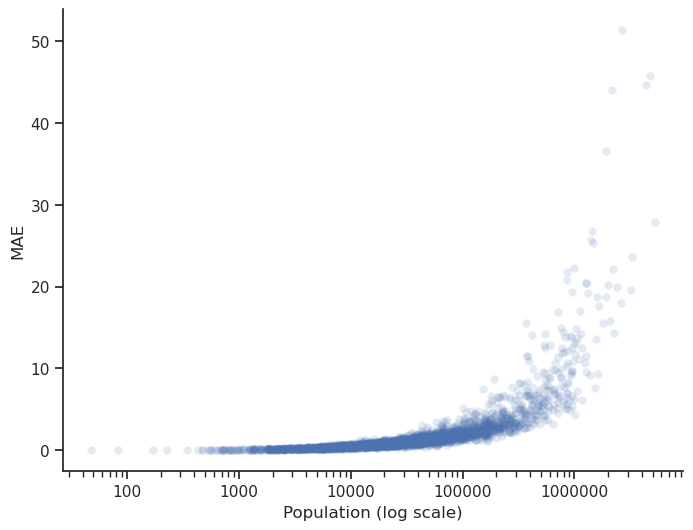

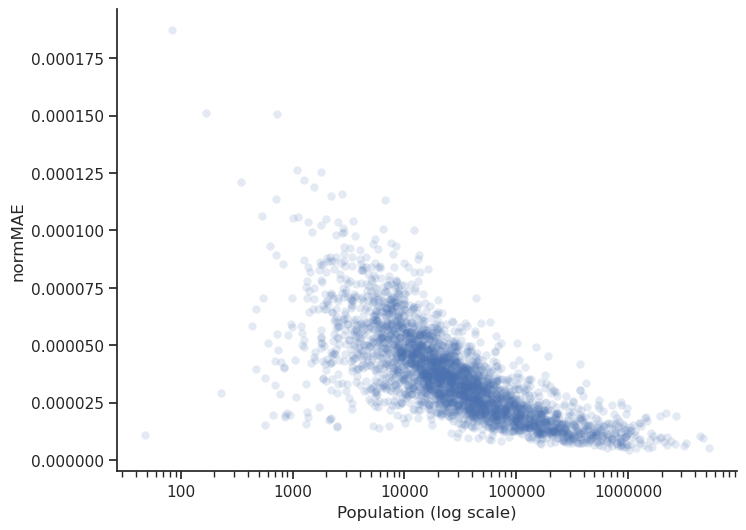

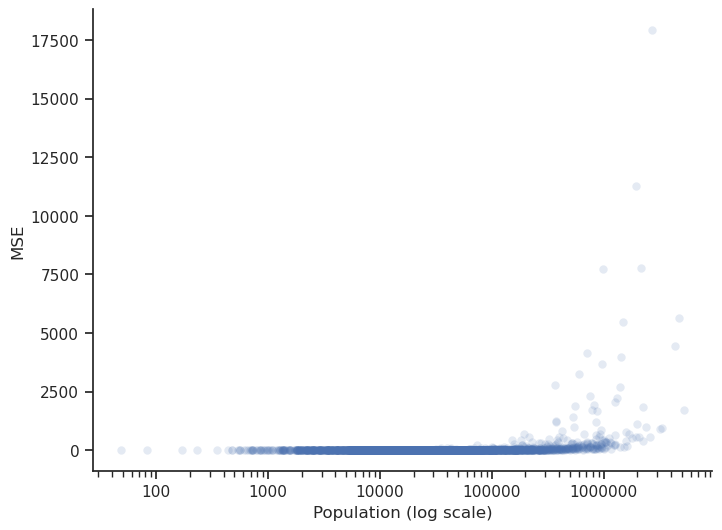

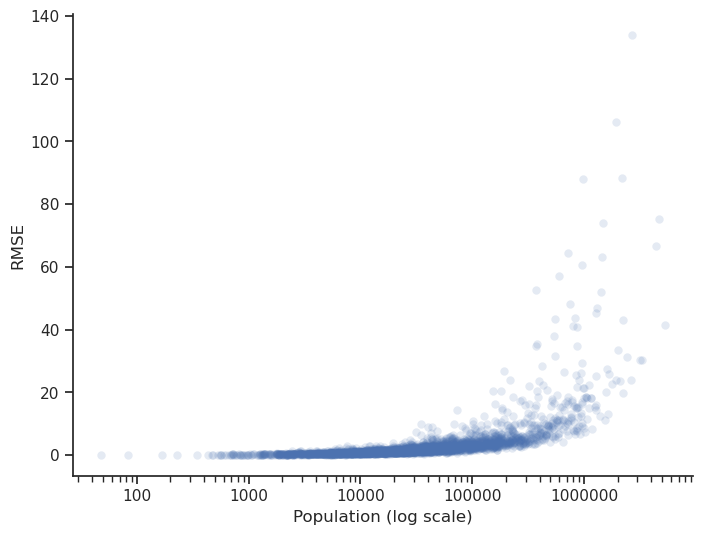

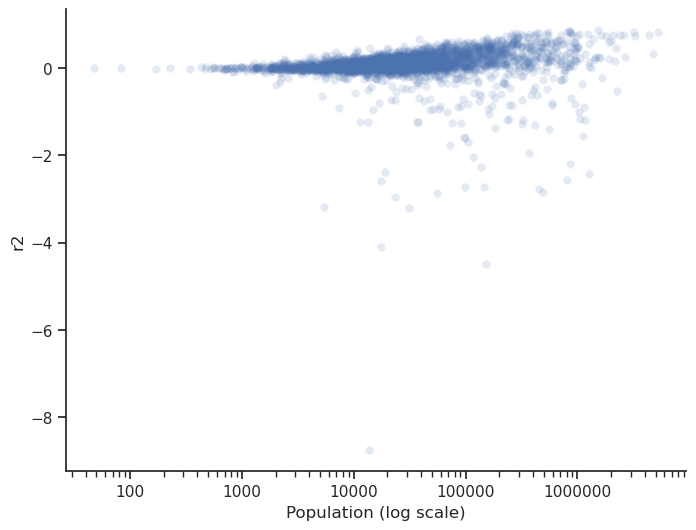

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

from matplotlib import ticker as mtick

figsize = (8,6)
alpha = 0.15
sizes = 2
linewidth = 0

for metric in ['MAE', 'normMAE', 'MSE', 'RMSE', 'r2']:
# for metric in [ 'normMAE', ]:
    
    plt.figure(figsize=figsize)
    
    ax = sns.scatterplot(data=df, x="Pop", y=metric, alpha=alpha, sizes=sizes, linewidth=linewidth)
    
#     plt.xlabel('County population (log scale)')
    plt.xlabel('Population (log scale)')
#     plt.ylabel()
    
    plt.xscale('log')

    xticks = mtick.FormatStrFormatter('%d')
    plt.gca().xaxis.set_major_formatter(xticks)
    
    sns.despine()
    plt.show()

In [32]:
import numpy as np
import scipy.stats

print('normMAE vs. Pop *')
r = scipy.stats.pearsonr(df.normMAE, df.Pop)    # Pearson's r
rho = scipy.stats.spearmanr(df.normMAE, df.Pop)   # Spearman's rho
tau = scipy.stats.kendalltau(df.normMAE, df.Pop)   # Kendall's tau
display(r, rho, tau)


normMAE vs. Pop *


PearsonRResult(statistic=-0.3588419115994992, pvalue=9.291874525618262e-96)

SignificanceResult(statistic=-0.8029067258556304, pvalue=0.0)

SignificanceResult(statistic=-0.6207201815049106, pvalue=0.0)

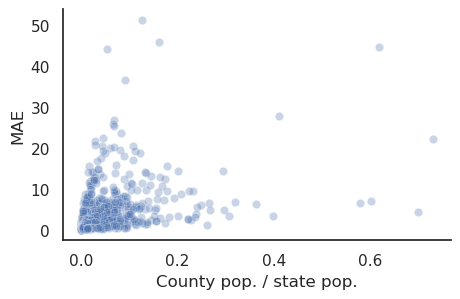

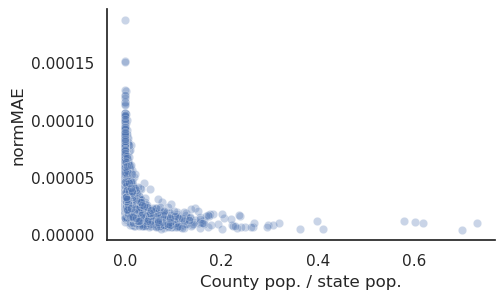

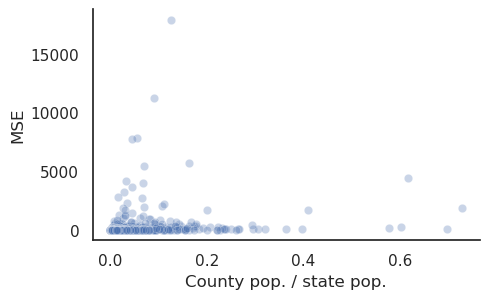

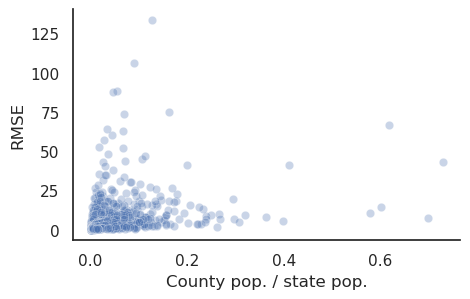

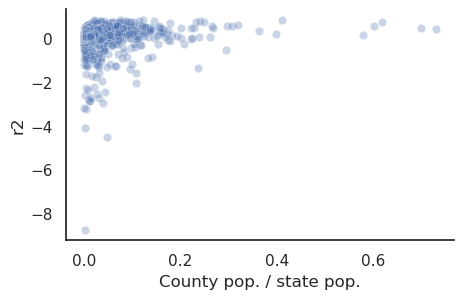

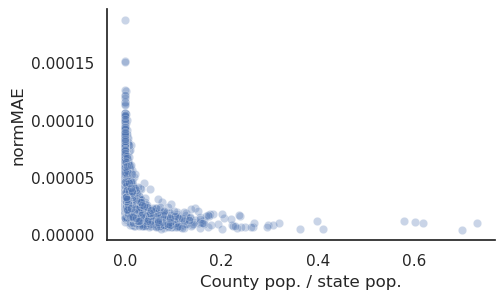

In [22]:
for metric in ['MAE',  'normMAE','MSE', 'RMSE', 'r2','normMAE']:
    
    plt.figure(figsize=figsize)
    
    ax = sns.scatterplot(data=df, x="Ratio", y=metric, alpha=0.3, sizes=5)
    
    plt.xlabel('County pop. / state pop.')
#     plt.xscale('log')
    
    sns.despine()
    plt.show()

In [33]:
import numpy as np
import scipy.stats

print('r2 vs. Ratio *')
r = scipy.stats.pearsonr(df.r2, df.Ratio)    # Pearson's r
rho = scipy.stats.spearmanr(df.r2, df.Ratio)   # Spearman's rho
tau = scipy.stats.kendalltau(df.r2, df.Ratio)   # Kendall's tau
display(r, rho, tau)

print('\nr2 vs. Pop *')
r = scipy.stats.pearsonr(df.r2, df.Pop)    # Pearson's r
rho = scipy.stats.spearmanr(df.r2, df.Pop)   # Spearman's rho
tau = scipy.stats.kendalltau(df.r2, df.Pop)   # Kendall's tau
display(r, rho, tau)

print('\nMAE vs. Ratio *')
r = scipy.stats.pearsonr(df.MAE, df.Ratio)    # Pearson's r
rho = scipy.stats.spearmanr(df.MAE, df.Ratio)   # Spearman's rho
tau = scipy.stats.kendalltau(df.MAE, df.Ratio)   # Kendall's tau
display(r, rho, tau)

print('\nMAE vs. Pop *')
r = scipy.stats.pearsonr(df.MAE, df.Pop)    # Pearson's r
rho = scipy.stats.spearmanr(df.MAE, df.Pop)   # Spearman's rho
tau = scipy.stats.kendalltau(df.MAE, df.Pop)   # Kendall's tau
display(r, rho, tau)

print('\nRMSE vs. Ratio *')
r = scipy.stats.pearsonr(df.RMSE, df.Ratio)    # Pearson's r
rho = scipy.stats.spearmanr(df.RMSE, df.Ratio)   # Spearman's rho
tau = scipy.stats.kendalltau(df.RMSE, df.Ratio)   # Kendall's tau
display(r, rho, tau)

print('\nRMSE vs. Pop *')
r = scipy.stats.pearsonr(df.RMSE, df.Pop)    # Pearson's r
rho = scipy.stats.spearmanr(df.RMSE, df.Pop)   # Spearman's rho
tau = scipy.stats.kendalltau(df.RMSE, df.Pop)   # Kendall's tau
display(r, rho, tau)

r2 vs. Ratio *


PearsonRResult(statistic=0.11297453129011271, pvalue=2.3232219455680352e-10)

SignificanceResult(statistic=0.4159356599598011, pvalue=3.2446710565305164e-131)

SignificanceResult(statistic=0.29622151629498134, pvalue=2.9553506441068516e-136)


r2 vs. Pop *


PearsonRResult(statistic=0.11187350921675937, pvalue=3.471026521299247e-10)

SignificanceResult(statistic=0.4325597713635211, pvalue=6.442266343926369e-143)

SignificanceResult(statistic=0.31045480448465246, pvalue=1.8294018502561826e-149)


MAE vs. Ratio *


PearsonRResult(statistic=0.5001694090802524, pvalue=7.890189894705382e-198)

SignificanceResult(statistic=0.7032494153471192, pvalue=0.0)

SignificanceResult(statistic=0.5169756403280521, pvalue=0.0)


MAE vs. Pop *


PearsonRResult(statistic=0.8904256878285632, pvalue=0.0)

SignificanceResult(statistic=0.9500766943330498, pvalue=0.0)

SignificanceResult(statistic=0.8116927845043642, pvalue=0.0)


RMSE vs. Ratio *


PearsonRResult(statistic=0.40096822759625905, pvalue=3.1322598347133283e-121)

SignificanceResult(statistic=0.663503433936746, pvalue=0.0)

SignificanceResult(statistic=0.47935171842423735, pvalue=0.0)


RMSE vs. Pop *


PearsonRResult(statistic=0.7527120740025502, pvalue=0.0)

SignificanceResult(statistic=0.8968158344356054, pvalue=0.0)

SignificanceResult(statistic=0.7244485178317457, pvalue=0.0)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1, style='ticks') 

# from matplotlib import ticker as mtick

# sns.scatterplot(data=dff, x="Pop", y="r2")
# plt.xlabel('County population')

# fmt = '%d'  # as per no of zero(or other) you want after decimal point
# xticks = mtick.FormatStrFormatter(fmt)
# plt.gca().xaxis.set_major_formatter(xticks)
# plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1, style='ticks') 

# from matplotlib import ticker as mtick

# sns.scatterplot(data=dff, x="Ratio", y="r2")
# plt.xlabel('County ratio')

# # fmt = '%d'  # as per no of zero(or other) you want after decimal point
# # xticks = mtick.FormatStrFormatter(fmt)
# # plt.gca().xaxis.set_major_formatter(xticks)
# plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1, style='ticks') 

# from matplotlib import ticker as mtick

# sns.scatterplot(data=dff, x="Pop", y="RMSE")
# plt.xlabel('County population')

# fmt = '%d'  # as per no of zero(or other) you want after decimal point
# xticks = mtick.FormatStrFormatter(fmt)
# plt.gca().xaxis.set_major_formatter(xticks)
# plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1, style='ticks') 

# from matplotlib import ticker as mtick

# sns.scatterplot(data=dff, x="Pop", y="MAE")
# plt.xlabel('County population')

# fmt = '%d'  # as per no of zero(or other) you want after decimal point
# xticks = mtick.FormatStrFormatter(fmt)
# plt.gca().xaxis.set_major_formatter(xticks)
# plt.show()